In [446]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score
import numpy as np

# Cargar datos
df_gemma = pd.read_excel("./datos/Clasificación_gemma2-9b-it-Completo.xlsx")
df_llama8b = pd.read_excel("./datos/Clasificación_llama-3.1-8b-instant-Completo.xlsx")
df_llama70b = pd.read_excel("./datos/Clasificación_llama-3.3-70b-versatile-Completo.xlsx")
df_gpt = pd.read_excel("./datos/Clasificación_GPT-4o-mini-Completo.xlsx")


In [447]:
true_col = 'Polarity'

prompt_cols_gemma = [
    'Polarity_gemma2-9b-it_ZeroShot',
    'Polarity_gemma2-9b-it_FewShot',
    'Polarity_gemma2-9b-it_Chain_Of_Thought'
]

prompt_cols_llama8b = [
    'Polarity_llama-3.1-8b-instant_ZeroShot',
    'Polarity_llama-3.1-8b-instant_FewShot',
    'Polarity_llama-3.1-8b-instant_Chain_Of_Thought'
]

prompt_cols_llama70b = [
    'Polarity_llama-3.3-70b-versatile_ZeroShot',
    'Polarity_llama-3.3-70b-versatile_FewShot',
    'Polarity_llama-3.3-70b-versatile_Chain_Of_Thought'
]

prompt_cols_gpt = [
    'Polarity_GPT-4o-mini_ZeroShot',
    'Polarity_GPT-4o-mini_FewShot',
    'Polarity_GPT-4o-mini_Chain_Of_Thought'
]

prompt_names = ['ZeroShot', 'FewShot', 'Chain of Thought']

expected_labels = {"NEG", "NEU", "POS"}

# Función para reemplazar etiquetas no válidas
def normalize_label(label):
    if pd.isna(label):
        return "INVAL"
    return label if label in expected_labels else "INVAL"


# Aplicar normalización al DataFrame
def normalize_dataframe(df, true_col, prompt_cols, normalize_label_func):
    df_normalized = df.copy()
    for col in [true_col] + prompt_cols:
        df_normalized[col] = df_normalized[col].apply(normalize_label_func)
    return df_normalized


df_normalized_gemma = normalize_dataframe(df_gemma, true_col, prompt_cols_gemma, normalize_label)
df_normalized_llama8b = normalize_dataframe(df_llama8b, true_col, prompt_cols_llama8b, normalize_label)
df_normalized_llama70b = normalize_dataframe(df_llama70b, true_col, prompt_cols_llama70b, normalize_label)
df_normalized_gpt = normalize_dataframe(df_gpt, true_col, prompt_cols_gpt, normalize_label)


In [448]:
def plot_aciertos_by_prompt(df_normalized, true_col, prompt_cols, prompt_names, model_name):
    # Calcular porcentaje de aciertos globales
    global_aciertos_results = []
    for col, name in zip(prompt_cols, prompt_names):
        correct = (df_normalized[col] == df_normalized[true_col]) & (df_normalized[true_col] != "INVAL")
        total_valid = (df_normalized[true_col] != "INVAL").sum()
        accuracy = correct.sum() / total_valid * 100
        global_aciertos_results.append((name, accuracy))
    
    # Calcular porcentaje de aciertos por polaridad
    polarity_aciertos_results = {label: [] for label in ["NEG", "NEU", "POS"]}
    for col, name in zip(prompt_cols, prompt_names):
        for label in ["NEG", "NEU", "POS"]:
            correct = (df_normalized[col] == df_normalized[true_col]) & (df_normalized[true_col] == label)
            total_label = (df_normalized[true_col] == label).sum()
            accuracy = correct.sum() / total_label * 100 if total_label > 0 else 0
            polarity_aciertos_results[label].append((name, accuracy))  #no es recall ni precision, es el porcentaje de aciertos por polaridad
            #calculamos el recall aunque no queramos ya que: verdaderos positivos / verdadedros reales
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(global_aciertos_results)) 
    width = 0.2 
    global_bars = ax.bar(x - width, [x[1] for x in global_aciertos_results], width, label='Global', color='grey')

    colors = {'NEG': 'red', 'NEU': 'lightblue', 'POS': 'lightgreen'}
    for i, label in enumerate(["NEG", "NEU", "POS"]):
        polar_bars = ax.bar(x + i * width, [x[1] for x in polarity_aciertos_results[label]], width, label=label, color=colors[label])

    ax.set_xlabel('Prompts')
    ax.set_ylabel('Porcentaje de aciertos (%)')
    ax.set_title(f'Porcentaje de aciertos por prompt y polaridad - {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels([x[0] for x in global_aciertos_results])
    ax.set_ylim(0, 100)
    ax.legend(title="Tipo de precisión")
    ax.grid(axis='y')
    
    for bars in [global_bars] + [ax.patches[i::len(global_aciertos_results)] for i in range(1, 4)]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [449]:
def plot_confusion_matrices(df, true_col, prompt_cols, prompt_names, model_name):
    filtered_df = df[[true_col] + prompt_cols].dropna()

    for col, name in zip(prompt_cols, prompt_names):
        cm = confusion_matrix(filtered_df[true_col], filtered_df[col], labels=["NEG", "NEU", "POS"], normalize='true')
        cm_percent = cm * 100  # convertir a porcentaje
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["NEG", "NEU", "POS"])
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, values_format='.2f', cmap='Blues')
        ax.set_title(f'Matriz de confusión 2019(%) - {name} ({model_name})')
        plt.xlabel('Predicción')
        plt.ylabel('Realidad')
        plt.tight_layout()
        plt.show()


In [450]:
def calcular_metricas_por_clase(df, true_col, pred_col, labels):
    resultados = []
    for label in labels:
        tp = ((df[true_col] == label) & (df[pred_col] == label)).sum()
        tn = ((df[true_col] != label) & (df[pred_col] != label)).sum()
        fp = ((df[true_col] != label) & (df[pred_col] == label)).sum()
        fn = ((df[true_col] == label) & (df[pred_col] != label)).sum()

        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        resultados.append({
            "Clase": label,
            "Accuracy": round(accuracy, 4),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-score": round(f1, 4)
        })
    return pd.DataFrame(resultados).set_index("Clase")

In [451]:
for df_norm, prompt_cols, model_name in model_data:
    print(f"\n=== {model_name} ===")
    for col, name in zip(prompt_cols, prompt_names):
        print(f"\n--- Prompt: {name} ---")
        display(calcular_metricas_por_clase(df_norm, true_col, col, expected_labels))



=== GEMMA ===

--- Prompt: ZeroShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8585,0.8298,0.7712,0.7994
NEU,0.6890,0.2707,0.6786,0.3870
NEG,0.7665,0.9306,0.5654,0.7034



--- Prompt: FewShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8399,0.7625,0.8164,0.7885
NEU,0.7924,0.3195,0.3857,0.3495
NEG,0.8368,0.8762,0.7764,0.8233



--- Prompt: Chain of Thought ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8037,0.6745,0.8955,0.7694
NEU,0.8223,0.3431,0.2500,0.2893
NEG,0.8182,0.8763,0.7321,0.7977



=== LLAMA-3.1-8b-instant ===

--- Prompt: ZeroShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8151,0.8458,0.6045,0.7051
NEU,0.7924,0.1919,0.1357,0.1590
NEG,0.7934,0.7224,0.9388,0.8165



--- Prompt: FewShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8419,0.7930,0.7684,0.7805
NEU,0.8306,0.3378,0.1786,0.2336
NEG,0.8171,0.7695,0.8945,0.8273



--- Prompt: Chain of Thought ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8048,0.6774,0.8898,0.7692
NEU,0.8440,0.4068,0.1714,0.2412
NEG,0.8161,0.8333,0.7806,0.8061



=== LLAMA-3.3-70b-versatile ===

--- Prompt: ZeroShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8388,0.750,0.8390,0.7920
NEU,0.8079,0.287,0.2214,0.2500
NEG,0.8161,0.819,0.8017,0.8102



--- Prompt: FewShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8667,0.7863,0.8729,0.8273
NEU,0.8316,0.4000,0.3286,0.3608
NEG,0.8595,0.8674,0.8418,0.8544



--- Prompt: Chain of Thought ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8326,0.7243,0.8757,0.7928
NEU,0.7934,0.3101,0.3500,0.3289
NEG,0.8182,0.8901,0.7173,0.7944



=== GPT-4o-mini ===

--- Prompt: ZeroShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8667,0.8319,0.7966,0.8139
NEU,0.7769,0.3190,0.4786,0.3829
NEG,0.8192,0.8568,0.7574,0.8040



--- Prompt: FewShot ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8347,0.8277,0.6921,0.7538
NEU,0.7800,0.3128,0.4357,0.3642
NEG,0.8378,0.8323,0.8376,0.8349



--- Prompt: Chain of Thought ---


,Accuracy,Precision,Recall,F1-score
Clase,,,,
POS,0.8585,0.7863,0.8418,0.8131
NEU,0.7975,0.3228,0.3643,0.3423
NEG,0.8316,0.8608,0.7827,0.8199


In [452]:
def global_metrics(df, true_col, pred_col):
    # Eliminar filas con valores nulos
    filtered_df = df[[true_col, pred_col]].dropna()
    y_true = filtered_df[true_col]
    y_pred = filtered_df[pred_col]

    # Calcular métricas globales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("=== MÉTRICAS GLOBALES ===")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")

In [453]:
model_data = [
    (df_normalized_gemma, prompt_cols_gemma, "GEMMA"),
    (df_normalized_llama8b, prompt_cols_llama8b, "LLAMA-3.1-8b-instant"),
    (df_normalized_llama70b, prompt_cols_llama70b, "LLAMA-3.3-70b-versatile"),
    (df_normalized_gpt, prompt_cols_gpt, "GPT-4o-mini")
]

for df_norm, prompt_cols, model_name in model_data:
    for col, name in zip(prompt_cols, prompt_names):
        print(f"\n=== {model_name} | Prompt: {name} ===")
        global_metrics(df_norm, true_col, col)



=== GEMMA | Prompt: ZeroShot ===


=== MÉTRICAS GLOBALES ===
Accuracy  : 0.6570
Precision : 0.6770
Recall    : 0.6717
F1-score  : 0.6299

=== GEMMA | Prompt: FewShot ===
=== MÉTRICAS GLOBALES ===
Accuracy  : 0.7345
Precision : 0.6528
Recall    : 0.6595
F1-score  : 0.6538

=== GEMMA | Prompt: Chain of Thought ===
=== MÉTRICAS GLOBALES ===
Accuracy  : 0.7221
Precision : 0.6313
Recall    : 0.6258
F1-score  : 0.6188

=== LLAMA-3.1-8b-instant | Prompt: ZeroShot ===
=== MÉTRICAS GLOBALES ===
Accuracy  : 0.7004
Precision : 0.5867
Recall    : 0.5597
F1-score  : 0.5602

=== LLAMA-3.1-8b-instant | Prompt: FewShot ===
=== MÉTRICAS GLOBALES ===
Accuracy  : 0.7448
Precision : 0.6335
Recall    : 0.6138
F1-score  : 0.6138

=== LLAMA-3.1-8b-instant | Prompt: Chain of Thought ===
=== MÉTRICAS GLOBALES ===
Accuracy  : 0.7324
Precision : 0.6392
Recall    : 0.6139
F1-score  : 0.6055

=== LLAMA-3.3-70b-versatile | Prompt: ZeroShot ===
=== MÉTRICAS GLOBALES ===
Accuracy  : 0.7314
Precision : 0.6187
Recall    : 0.6207
F1-score  : 0.6174

=== 

In [454]:
# Accuacy: verdaderos positivos + verdaderos negativos / total de muestras
# Precision: verdaderos positivos / (verdaderos positivos + falsos positivos)
# Recall: verdaderos positivos / (verdaderos positivos + falsos negativos)
# F1: 2 * (precision * recall) / (precision + recall)

In [455]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calcular_metricas_globales(df_normalized, true_col, prompt_cols, prompt_names, model_name):
    global_data = []

    for col, prompt in zip(prompt_cols, prompt_names):
        y_true = df_normalized[true_col]
        y_pred = df_normalized[col]

        # Filtrar las entradas válidas
        mask = (y_true != "INVAL") & (y_pred != "INVAL")
        y_true_valid = y_true[mask]
        y_pred_valid = y_pred[mask]

        precision = precision_score(y_true_valid, y_pred_valid, average='macro')
        recall = recall_score(y_true_valid, y_pred_valid, average='macro')
        f1 = f1_score(y_true_valid, y_pred_valid, average='macro')
        acc = accuracy_score(y_true_valid, y_pred_valid)

        global_data.append({
            'Modelo': model_name,
            'Prompt': prompt.replace("Chain of Thought", "CoT"),
            'Modelo_Prompt': model_name + '\n' + prompt.replace("Chain of Thought", "CoT"),
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Accuracy': acc
        })

    return pd.DataFrame(global_data)


In [456]:
df_global_gemma = calcular_metricas_globales(df_normalized_gemma, true_col, prompt_cols_gemma, prompt_names, "gemma2-9b-it")
df_global_llama8b = calcular_metricas_globales(df_normalized_llama8b, true_col, prompt_cols_llama8b, prompt_names, "llama-3.1-8b-instant")
df_global_llama70b = calcular_metricas_globales(df_normalized_llama70b, true_col, prompt_cols_llama70b, prompt_names, "llama-3.3-70b-versatile")
df_global_gpt = calcular_metricas_globales(df_normalized_gpt, true_col, prompt_cols_gpt, prompt_names, "GPT-4o-mini")

# Unir todos
df_global = pd.concat([
    df_global_gemma,
    df_global_llama8b,
    df_global_llama70b,
    df_global_gpt
])


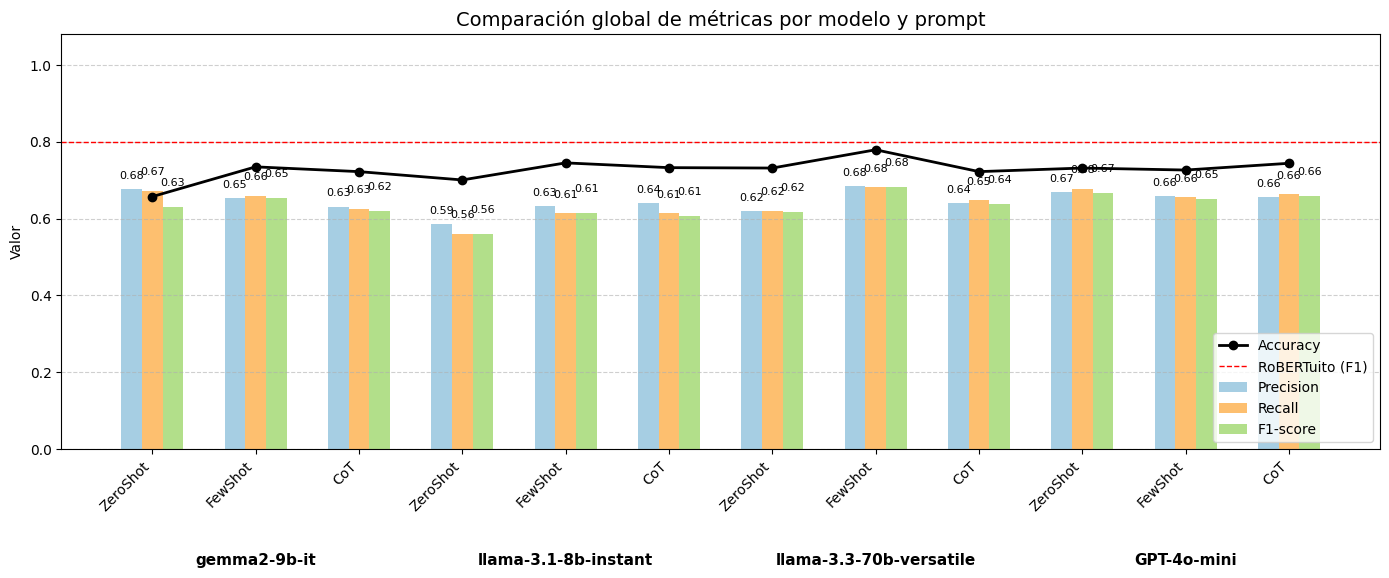

In [457]:
import matplotlib.pyplot as plt
import numpy as np

# Colores pastel
colors = {
    'Precision': '#a6cee3',
    'Recall': '#fdbf6f',
    'F1-score': '#b2df8a'
}

parametros = ['Precision', 'Recall', 'F1-score']

x = np.arange(len(df_global))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))

# Dibujar barras y etiquetas ajustadas
for j, param in enumerate(parametros):
    offset = (j - 1) * width
    bars = ax.bar(x + offset, df_global[param], width,
                  label=param, color=colors[param])
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Desplazamiento horizontal leve y vertical mayor para evitar solapes
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6 + j * 4),  # +4 pixeles por nivel
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=8)

# Línea de Accuracy
if 'Accuracy' in df_global.columns:
    ax.plot(x, df_global['Accuracy'], marker='o', color='black',
            label='Accuracy', linewidth=2)

# Línea horizontal de referencia
robertuito_f1_global = 0.80
ax.axhline(y=robertuito_f1_global, color='red', linestyle='--',
           label='RoBERTuito (F1)', linewidth=1)

# Etiquetas X
ax.set_xticks(x)
ax.set_xticklabels(df_global['Prompt'], rotation=45, ha='right')

# Texto de modelos debajo
modelos = df_global['Modelo'].tolist()
model_changes = [0] + [i for i in range(1, len(modelos)) if modelos[i] != modelos[i-1]] + [len(modelos)]
for i in range(len(model_changes) - 1):
    idx_start = model_changes[i]
    idx_end = model_changes[i + 1]
    mid = (idx_start + idx_end - 1) / 2
    if idx_start < len(modelos):
        ax.text(mid, -0.25, modelos[idx_start], ha='center', va='top',
                fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

# Ajustes finales
ax.set_ylim(0, 1.08)
ax.set_title('Comparación global de métricas por modelo y prompt', fontsize=14)
ax.set_ylabel('Valor')
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




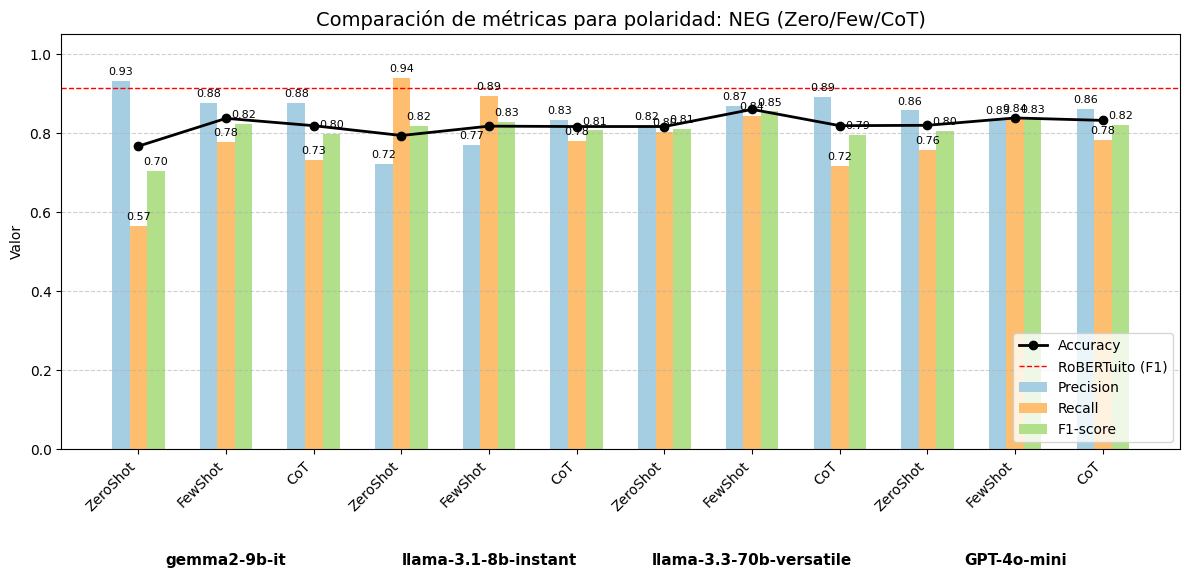

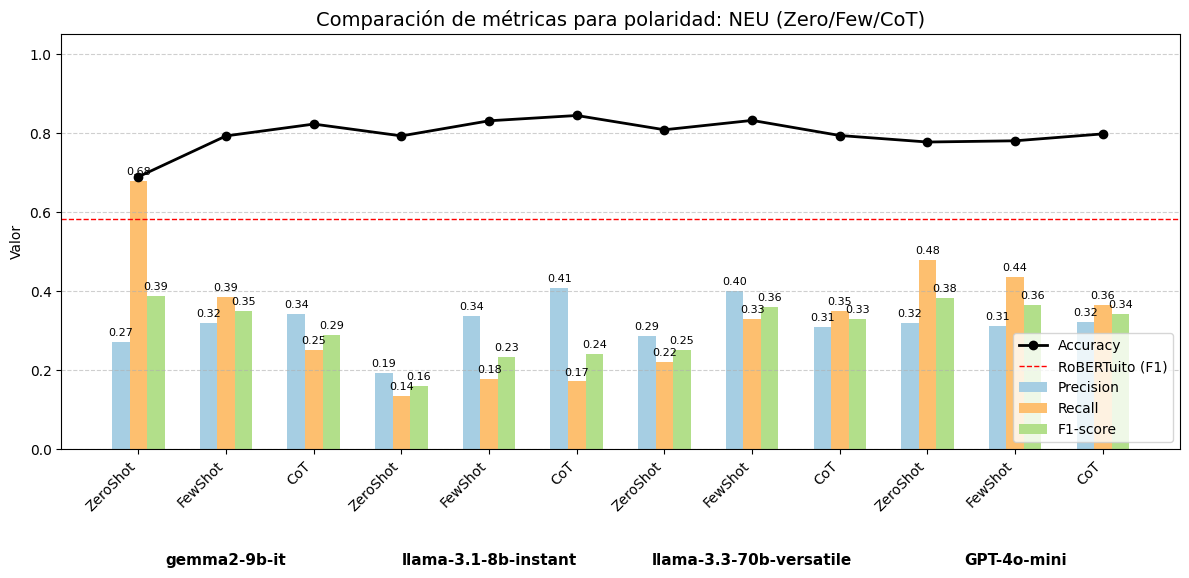

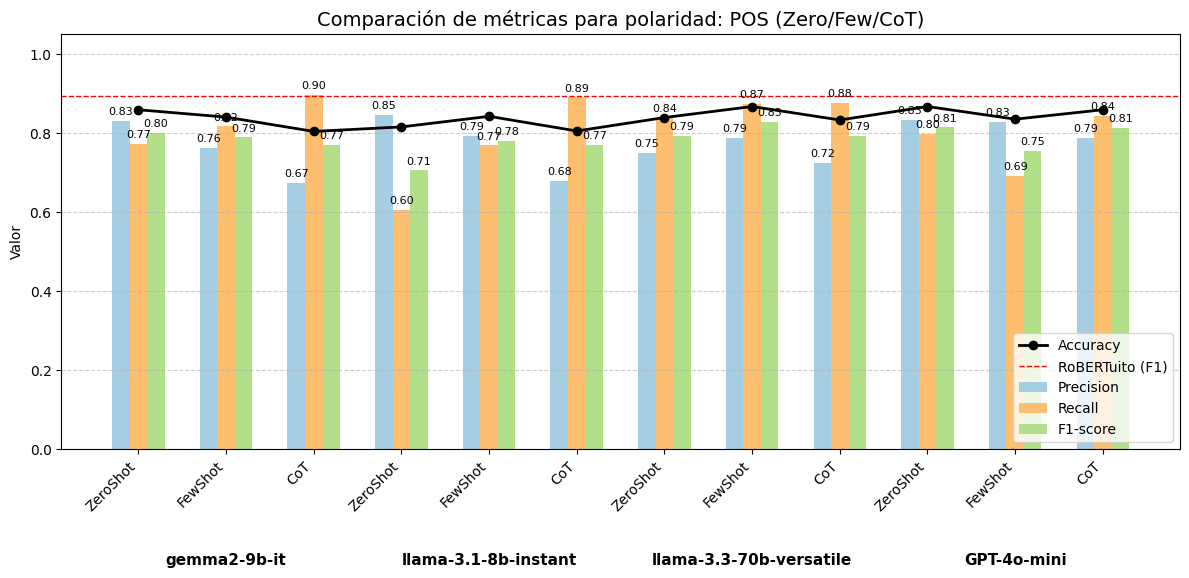

In [458]:
import matplotlib.pyplot as plt
import numpy as np

# Colores pastel
colors = {
    'Precision': '#a6cee3',  # azul pastel
    'Recall': '#fdbf6f',     # naranja pastel
    'F1-score': '#b2df8a'    # verde pastel
}

polarities = ['NEG', 'NEU', 'POS']
for pol in polarities:
    df_pol = metrics_all[metrics_all['Clase'] == pol].copy()

    # Renombrar "Chain of Thought" a "CoT"
    df_pol['Prompt'] = df_pol['Prompt'].replace({'Chain of Thought': 'CoT'})

    x = np.arange(len(df_pol['Modelo_Prompt']))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    for j, param in enumerate(parametros):
        bars = ax.bar(x + (j - 1)*width, df_pol[param], width,
                      label=param, color=colors[param])
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8)

    # Accuracy como línea
    ax.plot(x, df_pol['Accuracy'], marker='o', color='black',
            label='Accuracy', linewidth=2)

    # Línea horizontal RoBERTuito (F1)
    robertuito_f1 = {
        'NEG': 0.9130,
        'NEU': 0.5812,
        'POS': 0.8937
    }
    ax.axhline(y=robertuito_f1[pol], color='red', linestyle='--',
               label='RoBERTuito (F1)', linewidth=1)

    # Eje X
    prompts = df_pol['Prompt'].tolist()
    modelos = df_pol['Modelo'].tolist()
    ax.set_xticks(x)
    ax.set_xticklabels(prompts, rotation=45, ha='right')

    # Nombres de modelo (más abajo)
    model_changes = [0] + [i for i in range(1, len(modelos)) if modelos[i] != modelos[i-1]] + [len(modelos)]
    for i in range(len(model_changes)-1):
        idx_start = model_changes[i]
        idx_end = model_changes[i+1]
        mid = (idx_start + idx_end - 1) / 2
        ax.text(mid, -0.25, modelos[idx_start], ha='center', va='top',
                fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    ax.set_ylim(0, 1.05)
    ax.set_title(f'Comparación de métricas para polaridad: {pol} (Zero/Few/CoT)', fontsize=14)
    ax.set_ylabel('Valor')
    ax.legend(loc='lower right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()





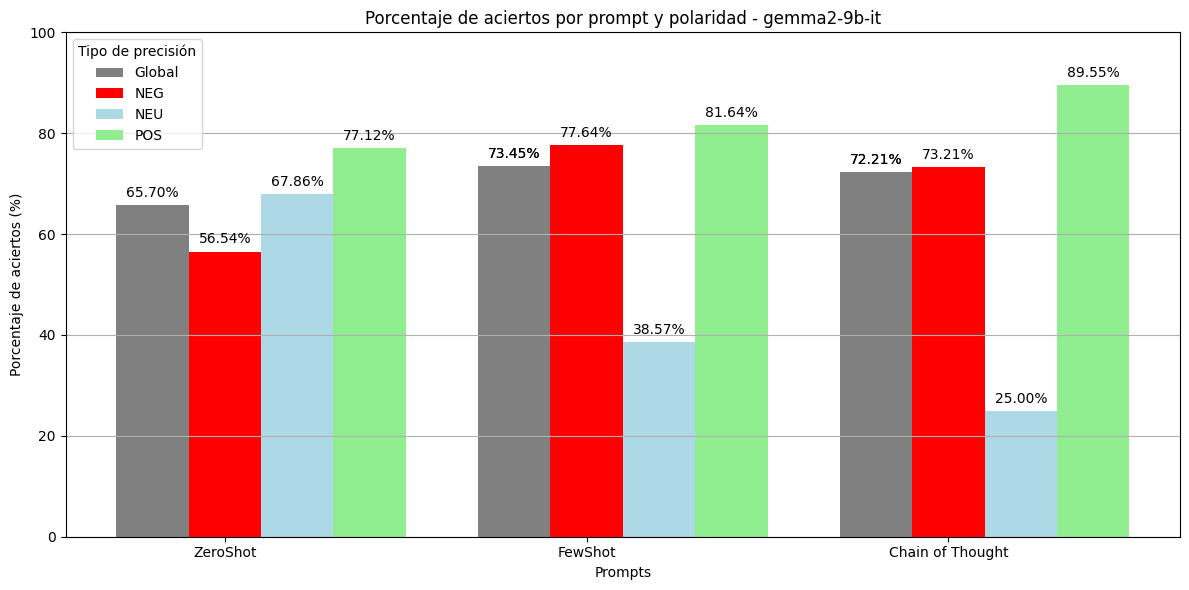

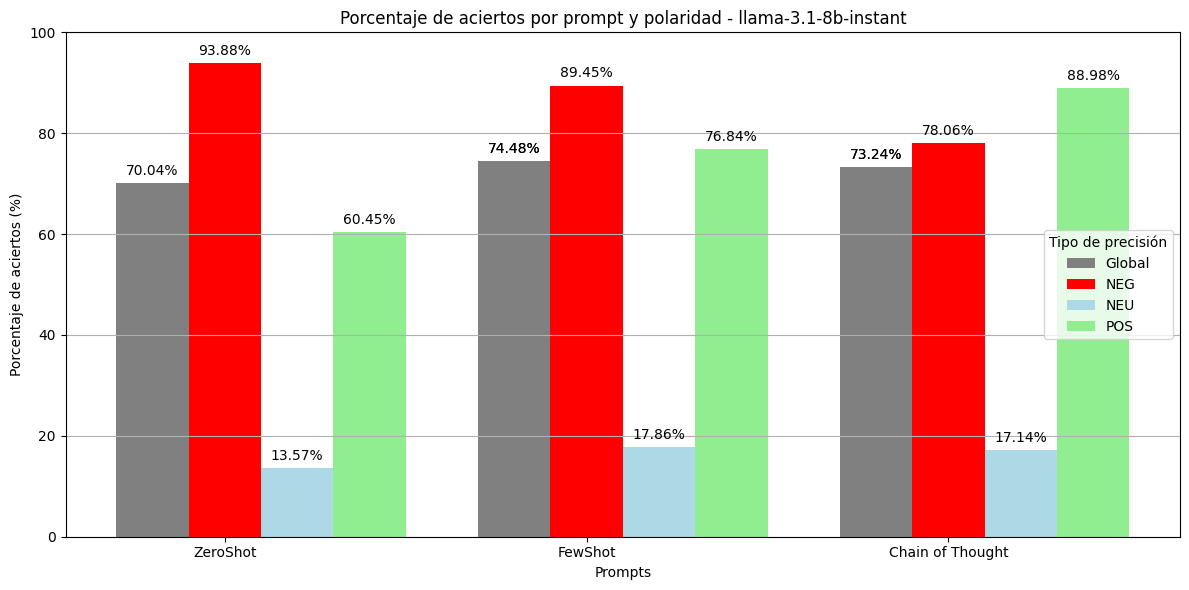

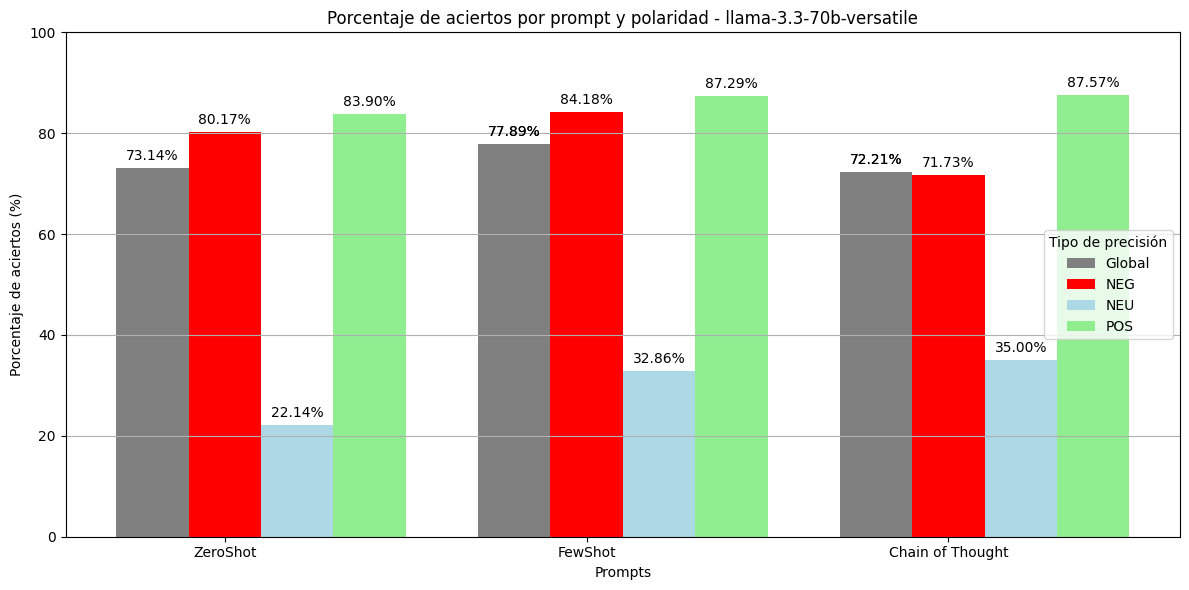

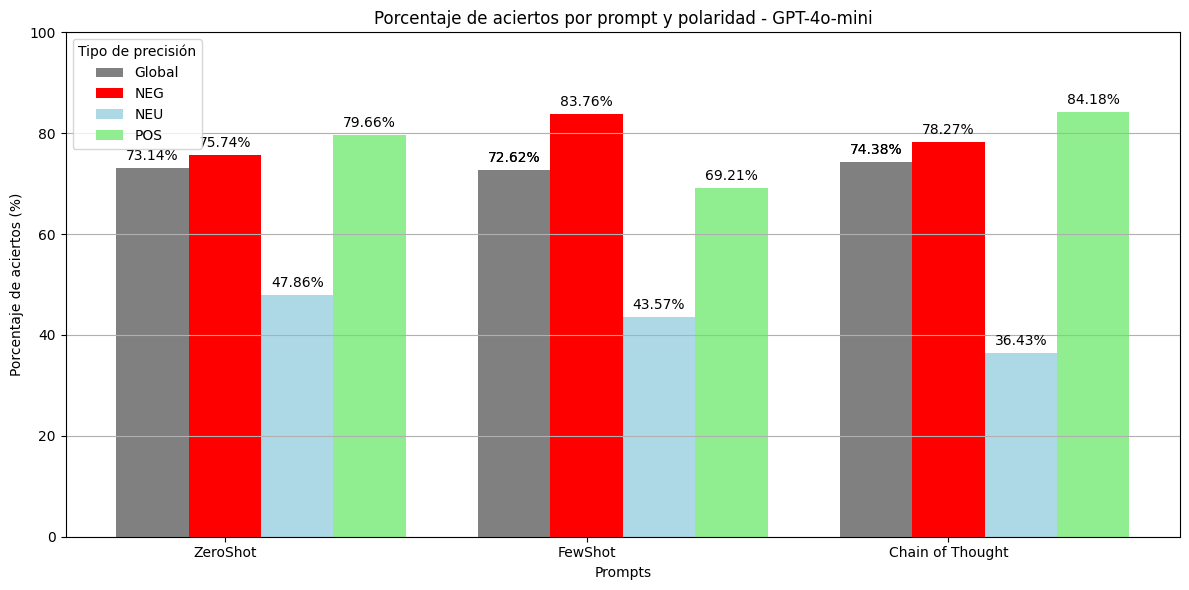

In [459]:
plot_aciertos_by_prompt(df_normalized_gemma, true_col, prompt_cols_gemma, prompt_names, "gemma2-9b-it")
plot_aciertos_by_prompt(df_normalized_llama8b, true_col, prompt_cols_llama8b, prompt_names, "llama-3.1-8b-instant")
plot_aciertos_by_prompt(df_normalized_llama70b, true_col, prompt_cols_llama70b, prompt_names, "llama-3.3-70b-versatile")
plot_aciertos_by_prompt(df_normalized_gpt, true_col, prompt_cols_gpt, prompt_names, "GPT-4o-mini")

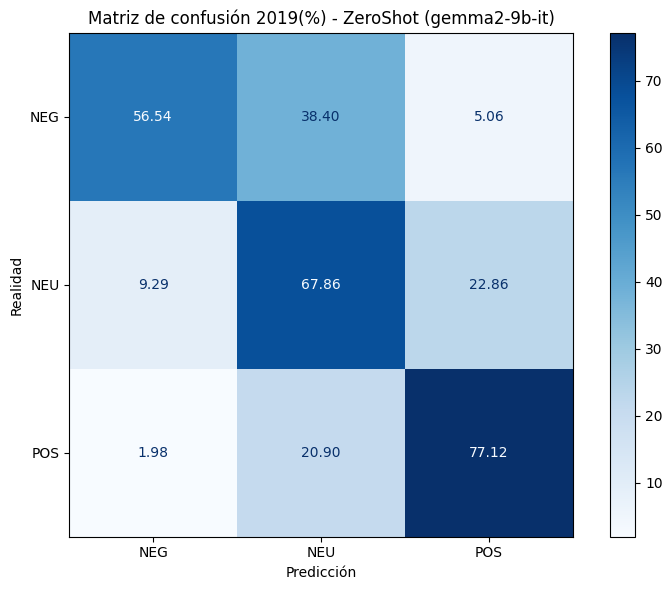

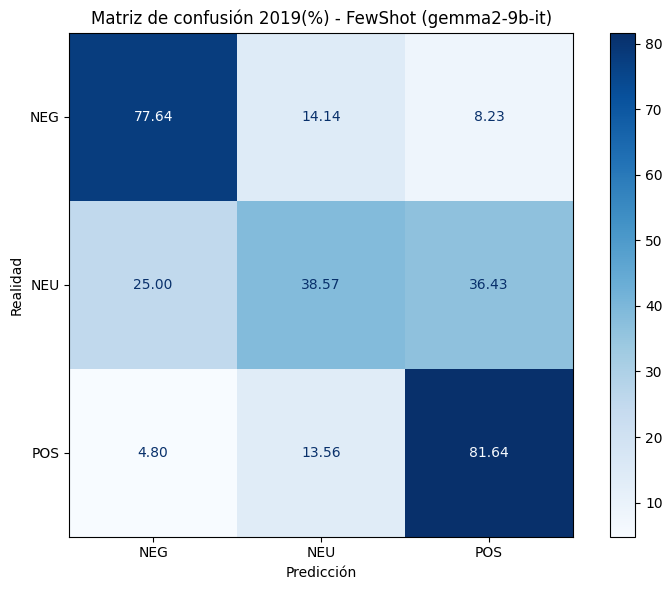

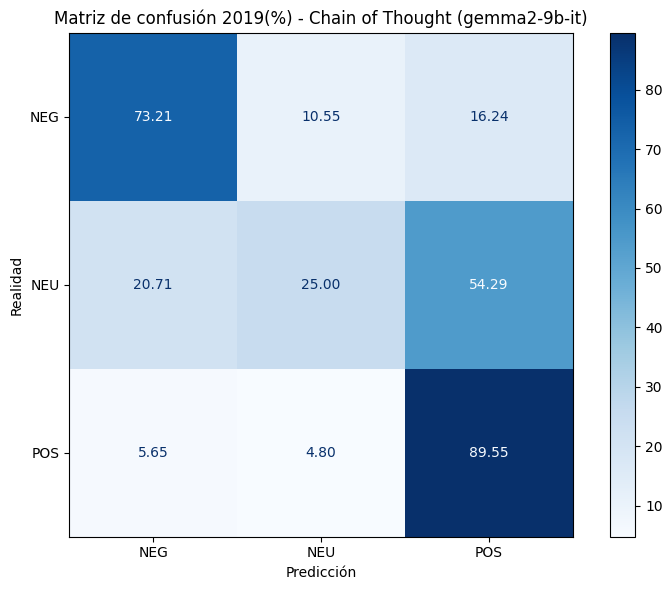

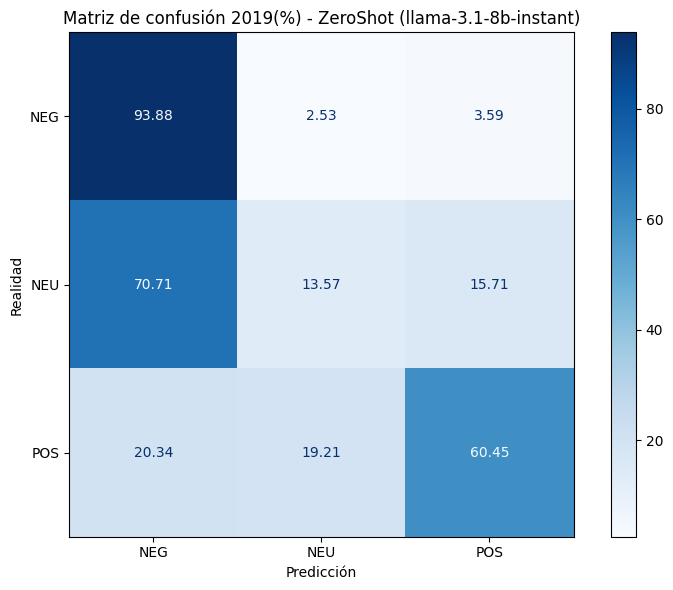

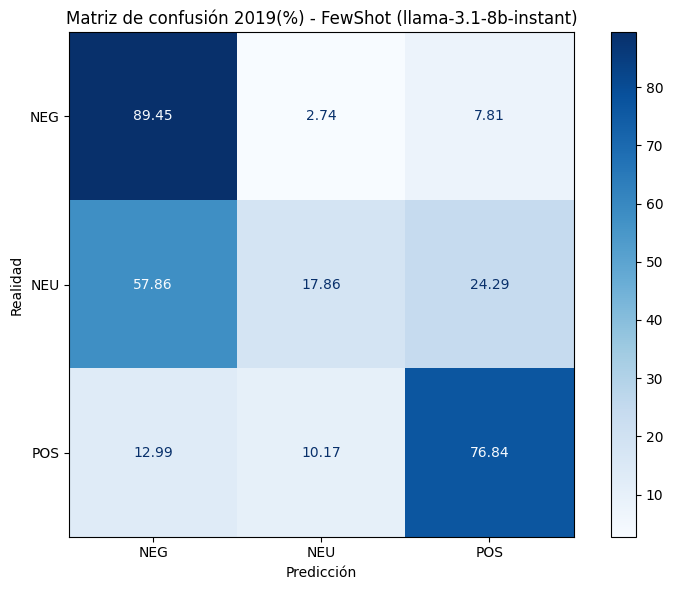

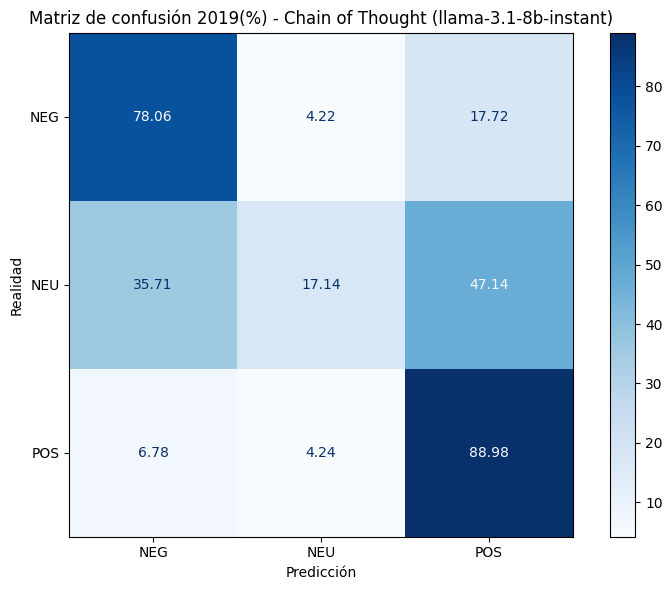

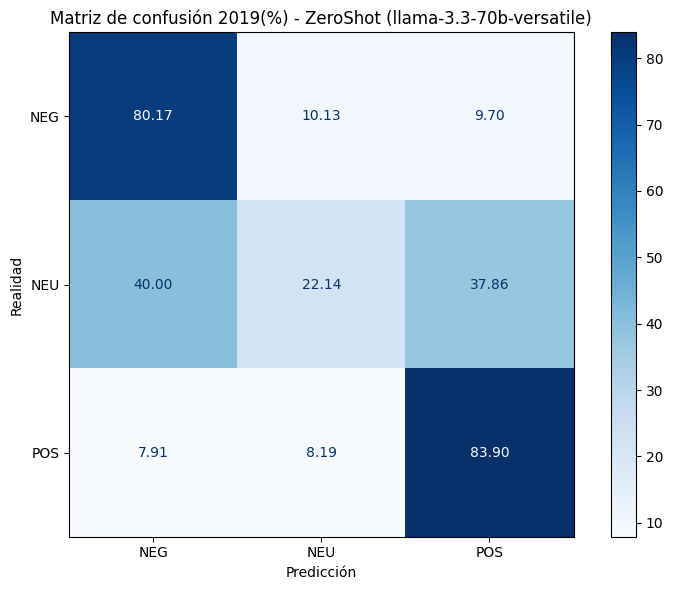

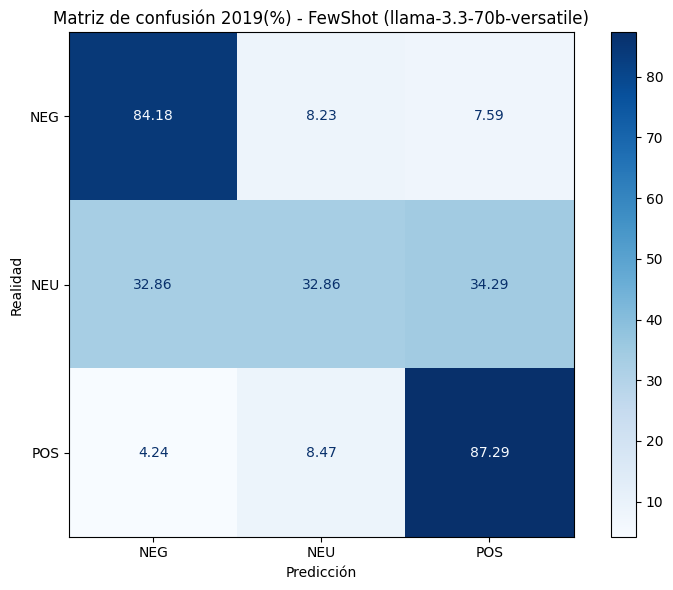

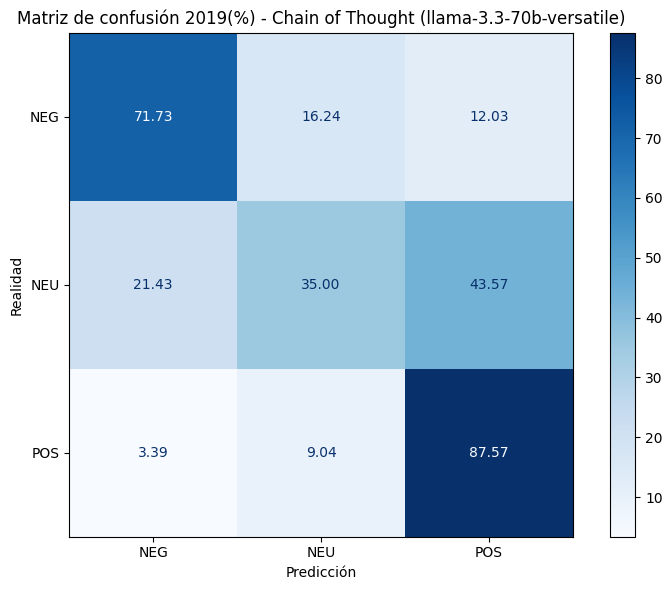

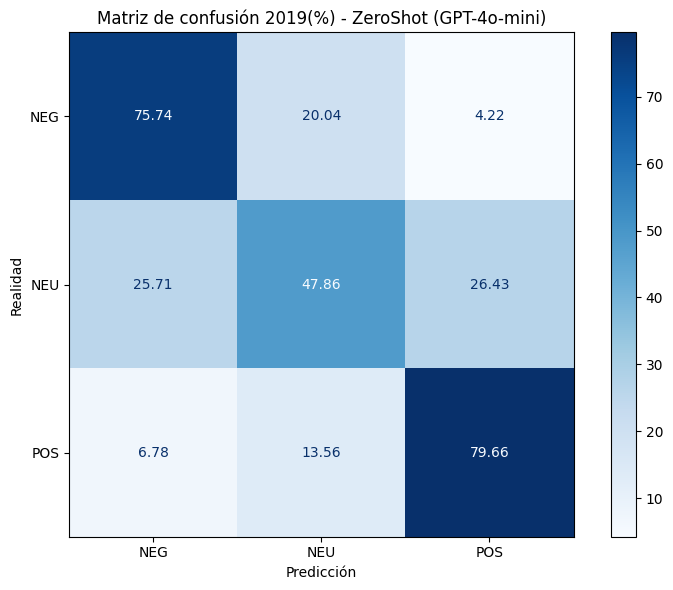

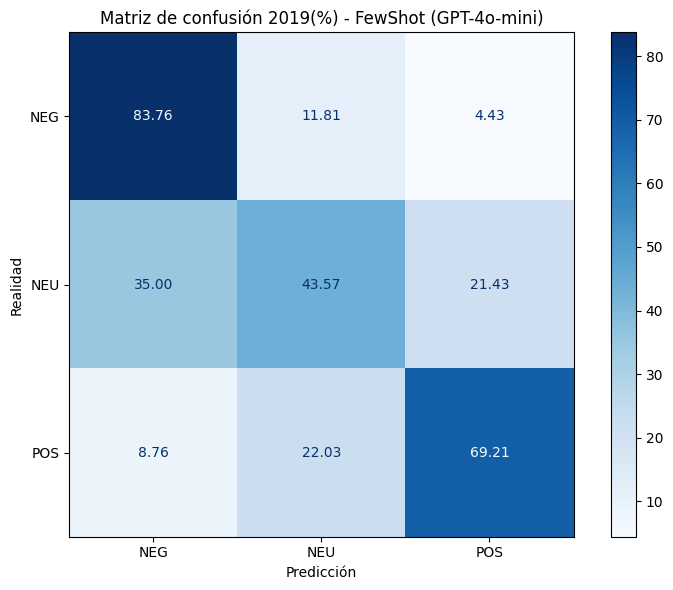

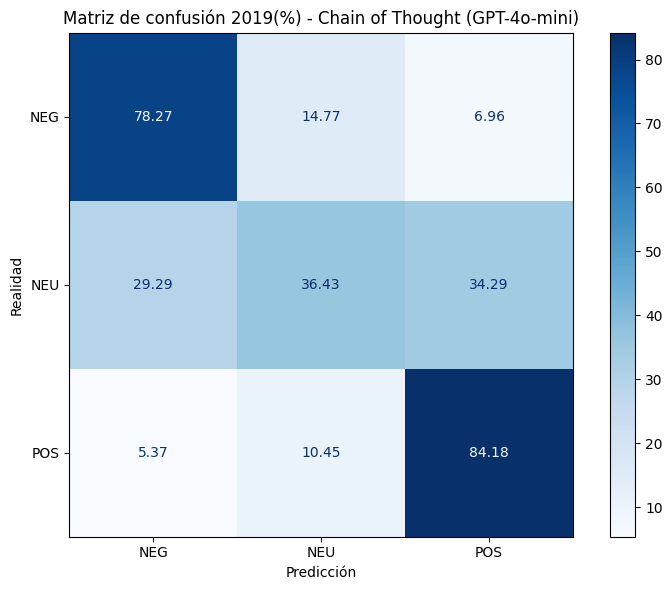

In [460]:
plot_confusion_matrices(df_normalized_gemma, true_col, prompt_cols_gemma, prompt_names, "gemma2-9b-it")
plot_confusion_matrices(df_normalized_llama8b, true_col, prompt_cols_llama8b, prompt_names, "llama-3.1-8b-instant")
plot_confusion_matrices(df_normalized_llama70b, true_col, prompt_cols_llama70b, prompt_names, "llama-3.3-70b-versatile")
plot_confusion_matrices(df_normalized_gpt, true_col, prompt_cols_gpt, prompt_names, "GPT-4o-mini")

In [461]:
metrics_df_gemma = calculate_metrics(df_normalized_gemma, prompt_cols_gemma, "gemma2-9b-it", true_col, prompt_names, expected_labels)
metrics_df_gemma

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,gemma2-9b-it,ZeroShot,POS,0.66,0.86,0.83,0.77,0.80
1,gemma2-9b-it,ZeroShot,NEU,0.66,0.69,0.27,0.68,0.39
2,gemma2-9b-it,ZeroShot,NEG,0.66,0.77,0.93,0.57,0.70
3,gemma2-9b-it,FewShot,POS,0.73,0.84,0.76,0.82,0.79
4,gemma2-9b-it,FewShot,NEU,0.73,0.79,0.32,0.39,0.35
5,gemma2-9b-it,FewShot,NEG,0.73,0.84,0.88,0.78,0.82
6,gemma2-9b-it,Chain of Thought,POS,0.72,0.80,0.67,0.90,0.77
7,gemma2-9b-it,Chain of Thought,NEU,0.72,0.82,0.34,0.25,0.29
8,gemma2-9b-it,Chain of Thought,NEG,0.72,0.82,0.88,0.73,0.80


In [462]:
metrics_df_gpt = calculate_metrics(df_normalized_gpt, prompt_cols_gpt, "GPT-4o-mini", true_col, prompt_names, expected_labels)
metrics_df_gpt

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,GPT-4o-mini,ZeroShot,POS,0.73,0.87,0.83,0.80,0.81
1,GPT-4o-mini,ZeroShot,NEU,0.73,0.78,0.32,0.48,0.38
2,GPT-4o-mini,ZeroShot,NEG,0.73,0.82,0.86,0.76,0.80
3,GPT-4o-mini,FewShot,POS,0.73,0.83,0.83,0.69,0.75
4,GPT-4o-mini,FewShot,NEU,0.73,0.78,0.31,0.44,0.36
5,GPT-4o-mini,FewShot,NEG,0.73,0.84,0.83,0.84,0.83
6,GPT-4o-mini,Chain of Thought,POS,0.74,0.86,0.79,0.84,0.81
7,GPT-4o-mini,Chain of Thought,NEU,0.74,0.80,0.32,0.36,0.34
8,GPT-4o-mini,Chain of Thought,NEG,0.74,0.83,0.86,0.78,0.82


In [463]:
metrics_df_llama8b = calculate_metrics(df_normalized_llama8b, prompt_cols_llama8b, "llama-3.1-8b-instant", true_col, prompt_names, expected_labels)
metrics_df_llama8b

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,llama-3.1-8b-instant,ZeroShot,POS,0.70,0.82,0.85,0.60,0.71
1,llama-3.1-8b-instant,ZeroShot,NEU,0.70,0.79,0.19,0.14,0.16
2,llama-3.1-8b-instant,ZeroShot,NEG,0.70,0.79,0.72,0.94,0.82
3,llama-3.1-8b-instant,FewShot,POS,0.74,0.84,0.79,0.77,0.78
4,llama-3.1-8b-instant,FewShot,NEU,0.74,0.83,0.34,0.18,0.23
5,llama-3.1-8b-instant,FewShot,NEG,0.74,0.82,0.77,0.89,0.83
6,llama-3.1-8b-instant,Chain of Thought,POS,0.73,0.80,0.68,0.89,0.77
7,llama-3.1-8b-instant,Chain of Thought,NEU,0.73,0.84,0.41,0.17,0.24
8,llama-3.1-8b-instant,Chain of Thought,NEG,0.73,0.82,0.83,0.78,0.81


In [464]:
metrics_df_llama70b = calculate_metrics(df_normalized_llama70b, prompt_cols_llama70b, "llama-3.3-70b-versatile", true_col, prompt_names, expected_labels)
metrics_df_llama70b

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,llama-3.3-70b-versatile,ZeroShot,POS,0.73,0.84,0.75,0.84,0.79
1,llama-3.3-70b-versatile,ZeroShot,NEU,0.73,0.81,0.29,0.22,0.25
2,llama-3.3-70b-versatile,ZeroShot,NEG,0.73,0.82,0.82,0.80,0.81
3,llama-3.3-70b-versatile,FewShot,POS,0.78,0.87,0.79,0.87,0.83
4,llama-3.3-70b-versatile,FewShot,NEU,0.78,0.83,0.40,0.33,0.36
5,llama-3.3-70b-versatile,FewShot,NEG,0.78,0.86,0.87,0.84,0.85
6,llama-3.3-70b-versatile,Chain of Thought,POS,0.72,0.83,0.72,0.88,0.79
7,llama-3.3-70b-versatile,Chain of Thought,NEU,0.72,0.79,0.31,0.35,0.33
8,llama-3.3-70b-versatile,Chain of Thought,NEG,0.72,0.82,0.89,0.72,0.79
